In [1]:
# Notebook: Model Selection - MCPA 911
# Author: Thomas Purk
# Date: 2025-03-23
# Reference: https://scikit-learn.org/stable/model_selection.html
# Reference: https://learn.microsoft.com/en-us/azure/machine-learning/algorithm-cheat-sheet?view=azureml-api-1

# NOTE: This notebook has model training steps. The GPU accelerator was turned on in Kaggle.

# Model Selection

The goal of the project is to see if machine learn could be helpful in deciding where to distrubute material and staffing among member regions. In this case where to deploy ambulances, police cruisers, fire trucks and staffing to townships and boroughs in Montgomery County, PA.

One factor that may influence the distribution decisions is future needs. Which machine leaning models could be used to predict future needs? Using the Algorithm Cheat Sheet from Microsoft, this project will explore the SciKit Learn and PyTorch equivelant models under the "Regression" heading.


[Machine Learning Algorithm Cheat Sheet](https://download.microsoft.com/download/3/5/b/35bb997f-a8c7-485d-8c56-19444dafd757/azure-machine-learning-algorithm-cheat-sheet-july-2021.pdf)

In this notebook, small explorations of several types of models will be completed to support final model selection

This notebook is part of an ML demonstation project. More information about the simulated project scenario and previous steps can be view in the GitHub.com repository [README.me](https://github.com/thomaspurk/ml-demo-911/blob/main/README.md)
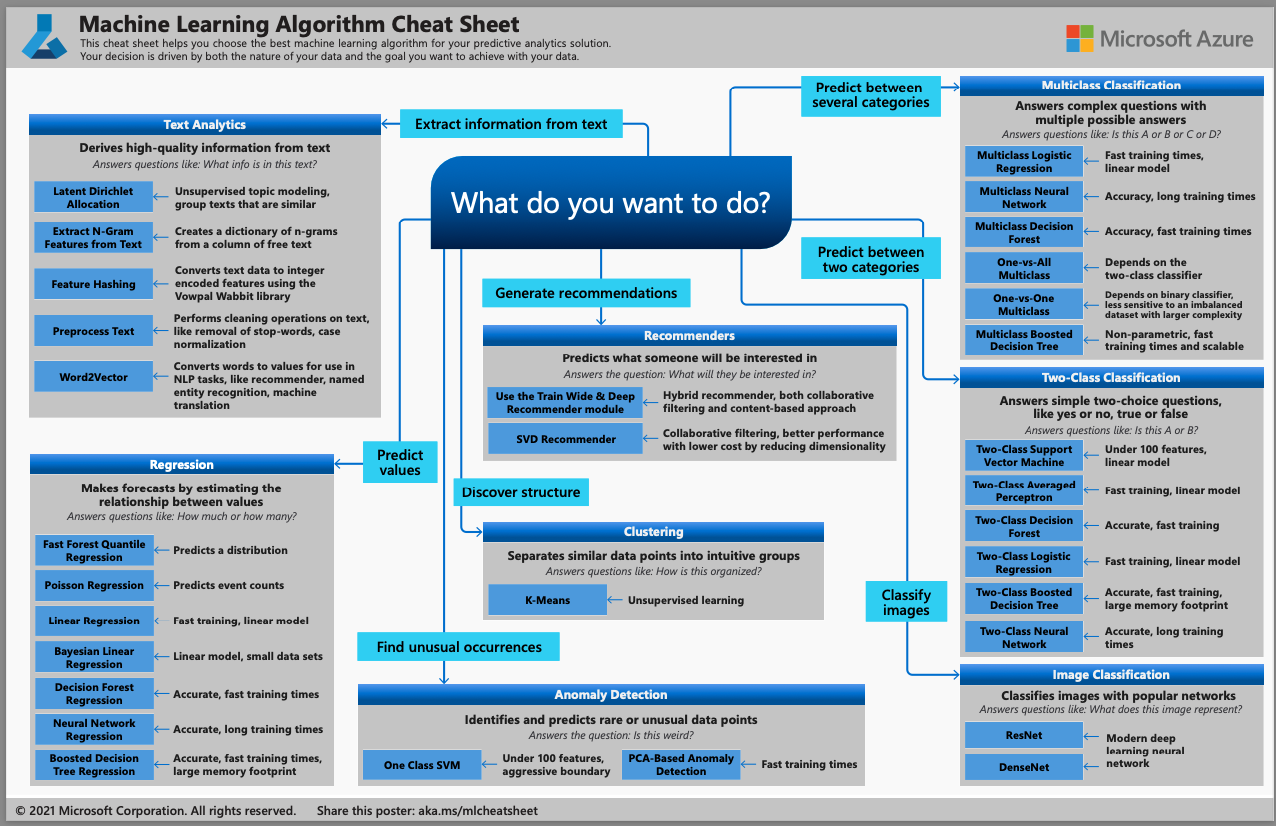

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emergency-911-calls-mcpa/911-processed.csv
/kaggle/input/emergency-911-calls-mcpa/911.csv
/kaggle/input/emergency-911-calls-mcpa/911-encoded.csv


In [3]:
# Validate package and version
!pip list | grep scipy
!pip list | grep sklearn

scipy                              1.13.1
sklearn-pandas                     2.2.0


In [4]:
# Notebook Step up steps

import scipy

# Prevent Pandas and other warnings from displaying above outputcells, improve readability
import warnings
warnings.filterwarnings('ignore')

# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load the data 
# NOTE: To try sklearn one-hot encoding instead of Pandas getdummies, load processed instead of encoded.
# df_in_path = '/kaggle/input/emergency-911-calls-mcpa/911-encoded.csv'
df_in_path = '/kaggle/input/emergency-911-calls-mcpa/911-processed.csv'
df_911 = pd.read_csv(df_in_path)
df_911.info() # validate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649696 entries, 0 to 649695
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   twp           649696 non-null  object
 1   e             649696 non-null  int64 
 2   service_type  649696 non-null  object
 3   service_desc  649696 non-null  object
 4   month         649696 non-null  int64 
 5   day_of_week   649696 non-null  int64 
 6   day_night     649696 non-null  object
dtypes: int64(3), object(4)
memory usage: 34.7+ MB


In [5]:
# SciKit Learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

# Encode data and labels
# Validate code on a subset of data first.
df_911_sub = df_911.sample(frac=1, random_state=42)
df_for_encoding = df_911_sub[['twp', 'month', 'day_of_week','day_night']]

# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(df_for_encoding)

# Prepare the features and labels
# Convert encoded features to a DataFrame
X = pd.DataFrame(
    data=encoded_features, 
    columns=encoder.get_feature_names_out()
)
# Convert labels to numerical formate
y = df_911_sub['service_type'].map({'Fire': 0, 'EMS': 1, 'Traffic': 3})

# Split the data training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

In [6]:
# Investigate a random forest classifier model
regressor = RandomForestClassifier(verbose=1,n_estimators=100)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

baseline_acc = accuracy_score(y_test, predictions)
print(f"Baseline Model Accuracy - Random Forest Classifier: {baseline_acc:.2f}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s


Baseline Model Accuracy - Random Forest Classifier: 0.52


In [7]:
# NOTE: Random Forrest Classifier did not product very good accuracy, 
# and it's not clear how the model would be useful. Try something else
# A model that could predict the number of events per category
# assuming category is a combination twp, service_type, service_description,
# could be used to run simulations of future activity

In [11]:
# Investigate a random forest regression model
from sklearn.ensemble import RandomForestRegressor

# Group the data to count the number of events per category.
# Columns of interest - Which type of vehicles (service type) does a township need the most?
df_911_sub = df_911[['twp', 'month', 'day_of_week','day_night', 'service_type', 'service_desc']]
# Grouping
group_911 = df_911_sub.groupby(['twp', 'month', 'day_of_week','day_night', 'service_type', 'service_desc'])
# New DataFrame
df_911_grouped = group_911.size().reset_index(name='call_count')

# Encode data and labels
# Validate code on a subset of data first.
df_911_sub = df_911_grouped.sample(frac=1, random_state=42)
df_for_encoding = df_911_sub[['twp', 'month', 'day_of_week','day_night', 'service_type', 'service_desc']]

# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(df_for_encoding)

# Prepare the features and labels
# Convert encoded features to a DataFrame
X = pd.DataFrame(
    data=encoded_features, 
    columns=encoder.get_feature_names_out()
)
# Convert labels to numerical formate
y = df_911_sub['call_count']

# Split the data training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("Random Forest Model Trained Successfully!")

# Make predictions on test data
y_pred = rf_model.predict(X_test)

# Evaluate model performance using MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 1.52
Root Mean Squared Error (RMSE): 2.99


In [15]:
# Evaluate the RMSE and MAE relative to the characteri
# Test Data characteristics
data_range = y_test.max() - y_test.min()
std_dev = np.std(y_test)

# Print comparison
print('--------- Baseline Model Metrics -------------')
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print('')
print('--------- Data Characterization --------------')
print(f"Test Data Range: {data_range}")
print(f"Test Data Standard Deviation: {std_dev:.2f}")
print('')
print('--------- Comparison & Insights --------------')
print(f"RMSE as % of Range: {rmse / data_range * 100:.2f}%")
print(f"MAE as % of Range: {mae / data_range * 100:.2f}%")
print(f"RMSE as % of Std Dev: {rmse / std_dev * 100:.2f}%")
print(f"MAE as % of Std Dev: {mae / std_dev * 100:.2f}%")

--------- Baseline Model Metrics -------------
Mean Absolute Error (MAE): 1.52
Root Mean Squared Error (RMSE): 2.99

--------- Data Characterization --------------
Test Data Range: 202
Test Data Standard Deviation: 7.24

--------- Comparison & Insights --------------
RMSE as % of Range: 1.48%
MAE as % of Range: 0.75%
RMSE as % of Std Dev: 41.23%
MAE as % of Std Dev: 21.02%


In [ ]:
# Observations
# Both the MAE (1.52) and RMSE (2.99) are a small portion of the min/max range (202) - good!
# Both the MAE (1.52) and RMSE (2.99) are smaller than STD (7.24) - good!
# Both the MAE (1.52) and RMSE (2.99) are a bit high percentage wise to STD (7.24) - a bit of a concern!
# RMSE (2.99) is a bit larger than MAE (1.52), and RMSE penalizes indvidual large error due to squaring
# --- means there are a few outliers. This makes sense due to the large difference in activity in
# --- rural vs urban townships. - makes sense!


In [12]:
X_test

,twp_AMBLER BOROUGH,twp_BRIDGEPORT BOROUGH,twp_BRYN ATHYN BOROUGH,twp_CHELTENHAM TOWNSHIP,twp_COLLEGEVILLE BOROUGH,twp_CONSHOHOCKEN BOROUGH,twp_DOUGLASS TOWNSHIP,twp_EAST GREENVILLE BOROUGH,twp_EAST NORRITON TOWNSHIP,twp_FRANCONIA TOWNSHIP,...,service_desc_TRASH/DUMPSTER FIRE,service_desc_UNCONSCIOUS SUBJECT,service_desc_UNKNOWN MEDICAL EMERGENCY,service_desc_UNKNOWN TYPE FIRE,service_desc_UNRESPONSIVE SUBJECT,service_desc_VEHICLE ACCIDENT,service_desc_VEHICLE FIRE,service_desc_VEHICLE LEAKING FUEL,service_desc_WARRANT SERVICE,service_desc_WOODS/FIELD FIRE
58127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147153,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
